In [1]:
import os
import sys
import re
from pathlib import Path
import pdfplumber
import pytesseract
from pdf2image import convert_from_path
import warnings
import logging
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

sys.path.append('../python')
warnings.filterwarnings('default')
logging.getLogger("pdfminer").setLevel(logging.ERROR)

import api

DATA_DIR = Path('../../raw_data/cpc')


/Users/ekung/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/ekung/Library/Python/3.9/lib/python/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# Count files and determine which meetings have supplemental-docs.pdf

file_count = 0
supp_doc_dirs = []
years = sorted([d.name for d in DATA_DIR.iterdir() if d.is_dir()])
for year in years:
    path = Path(f'../../raw_data/cpc/{year}')
    dates = sorted([d.name for d in path.iterdir() if d.is_dir()])
    for date in dates:
        path = Path(f'../../raw_data/cpc/{year}/{date}')
        files = [f.name for f in path.iterdir()]
        file_count += len(files)
        if 'supplemental-docs.pdf' in files:
            supp_doc_dirs.append(date)

print(f'Files: {file_count}')
print(supp_doc_dirs)

Files: 1526
['2018-05-10', '2018-05-23', '2018-06-14', '2018-07-12', '2018-07-26', '2018-08-09', '2018-08-23', '2018-09-13', '2018-09-27', '2018-10-11', '2018-10-25', '2018-11-08', '2018-11-29', '2018-12-13', '2018-12-20', '2019-01-10', '2019-01-24', '2019-02-14', '2019-02-28', '2019-03-14', '2019-03-28', '2019-04-11', '2019-05-09', '2019-05-23', '2019-06-13', '2019-06-27', '2019-07-11', '2019-07-25', '2019-08-08', '2019-08-22', '2019-09-12', '2019-09-26', '2019-10-10', '2019-10-24', '2019-11-14', '2019-11-21', '2019-12-12', '2019-12-19', '2020-01-09', '2020-01-23', '2020-02-13', '2020-03-12', '2020-04-23', '2020-05-14', '2020-05-28', '2020-06-04', '2020-06-11', '2020-06-25', '2020-07-09', '2020-07-23', '2020-08-13', '2020-08-27', '2020-09-10', '2020-09-17', '2020-09-24', '2020-10-08', '2020-10-15', '2020-10-22', '2020-11-05', '2020-11-19', '2020-12-03', '2020-12-10', '2020-12-17', '2021-01-14', '2021-01-21', '2021-01-28', '2021-02-11', '2021-02-18', '2021-02-25', '2021-03-11', '2021-0

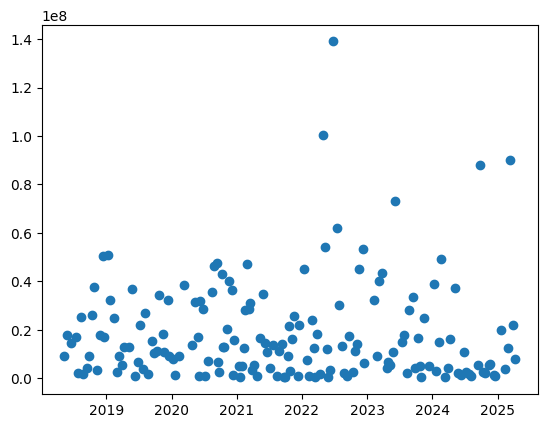

In [3]:
# check file size over time for supp docs
dates = []
sizes = []
for d in supp_doc_dirs:
    y = d[0:4]
    dates.append(pd.to_datetime(d))
    size = os.path.getsize(f'../../raw_data/cpc/{y}/{d}/supplemental-docs.pdf')
    sizes.append(size)
plt.scatter(dates, sizes)

In [6]:
df = pd.DataFrame({'date':dates, 'size':sizes})
df.sort_values(by='size', ascending=False)

,date,size
105,2022-06-23,139016535
100,2022-04-28,100461722
163,2025-03-13,89966514
153,2024-09-26,87887831
126,2023-06-08,73254779
...,...,...
135,2023-11-02,557766
84,2021-09-30,432693
83,2021-09-23,432693
97,2022-03-17,383524
